In [1]:
from pathlib import Path
import os
import numpy as np
from main import load_data
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from main import prior_from_weights

/home/dz/research/mave_calibration/main.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
data_dir = Path("/mnt/i/bio/mave_curation/")
results_dir = Path("/mnt/d/mave_calibration/results_08_09_24/")
with open(data_dir / "dataset_configs.json") as f:
    dataset_config = json.load(f)

In [3]:
data = {sample_name : load_data(dataset_id=sample_name,
                                data_directory=data_dir) \
        for sample_name in os.listdir(data_dir) if os.path.isdir(data_dir / sample_name) and sample_name in dataset_config}


standardizing to b_lb
standardizing to b_lb
standardizing to b_lb
standardizing to b_lb
standardizing to b_lb
standardizing to b_lb
standardizing to b_lb
standardizing to b_lb


In [21]:
import json
def read_result(r_dir):
    with open(r_dir / "result.json") as f:
        result = json.load(f)
    return result

def get_auc_intervals(r_dir,sample_num):
    CONFIDENCE_LEVEL = .1
    qmin,qmax = 100 * CONFIDENCE_LEVEL / 2, 100 * (1 - CONFIDENCE_LEVEL/2)
    with open(r_dir / "aucs.json") as f:
        aucs = json.load(f)
    intervals = {k : np.percentile(v[sample_num], [qmin,qmax]) for k, v in aucs.items()}
    overlapping = intervals['empirical'][1] < intervals['null'][0] or \
                    intervals['empirical'][0] > intervals['null'][1]
    return overlapping

In [22]:
rejections = []
for iter_result in results_dir.glob(f"iter_*/vanLoggerenberg_HMBS_ubiquitous"):
        if not os.path.isfile(iter_result / "aucs.json"):
            continue
        o  = get_auc_intervals(iter_result,1)
        rejections.append(o)
print(np.unique(rejections, return_counts=True))


(array([False,  True]), array([246,   8]))


In [5]:
def get_oob_indices(result, X):
    return np.array(list(set(list(range(X.shape[0]))) - \
                         set(np.concatenate(result["bootstrap_indices"]))))

In [6]:
from mave_calibration.skew_normal import density_utils
def get_lrPlus(S, result,pathogenic_sample_num=0, benign_sample_num=1):
    f_P = density_utils.joint_densities(S, result['component_params'], result['weights'][pathogenic_sample_num]).sum(0)
    f_B = density_utils.joint_densities(S, result['component_params'], result['weights'][benign_sample_num]).sum(0)
    return f_P / f_B

In [7]:
def predict_on_oob(result, X):
    oob_indices = get_oob_indices(result, X)
    predictions = np.ones(X.shape[0]) * np.nan
    oob_obs = X[oob_indices]
    predictions[oob_indices] = get_lrPlus(oob_obs, result)
    return predictions


In [8]:
def get_oob_predictions(dataset_name,sample_num=None, return_quantiles=False, return_all=False):
    X,S = data[dataset_name][:2]
    if sample_num is not None:
        x_sample = X[S[:,sample_num]]
    else:
        x_sample = X
    preds = []
    for iter_result in results_dir.glob(f"iter_*/{dataset_name}"):
        result = read_result(iter_result)
        preds.append(predict_on_oob(result, x_sample))
    P = np.stack(preds)
    if return_all:
        return P
    quantiles = np.nanquantile(P, [0.25, .5, 0.75], axis=0)
    if return_quantiles:
        return quantiles[1], quantiles[[0,-1],:]
    return quantiles[1]

def predict(X, dataset_name, return_quantiles=False, return_all=False):
    preds = []
    for iter_result in results_dir.glob(f"iter_*/{dataset_name}"):
        if not os.path.isfile(iter_result / "result.json"):
            continue
        result = read_result(iter_result)
        preds.append(get_lrPlus(X, result))
    P = np.stack(preds)
    if return_all:
        return P
    quantiles = np.nanquantile(P, [0.25, .5, 0.75], axis=0)
    if return_quantiles:
        return quantiles[1], quantiles[[0,-1],:]
    return quantiles[1]

def get_priors(dataset_name):
    priors = []
    for iter_result in results_dir.glob(f"iter_*/{dataset_name}"):
        if not os.path.isfile(iter_result / "result.json"):
            continue
        result = read_result(iter_result)
        priors.append(prior_from_weights(np.array(result['weights'])))
    return priors

def get_sample_density(X, dataset_name):
    densities = []
    for iter_result in results_dir.glob(f"iter_*/{dataset_name}"):
        result = read_result(iter_result)
        iter_densities = [density_utils.joint_densities(X, result['component_params'], result['weights'][i]).sum(0) \
                          for i in range(len(result['sample_names']))]
        densities.append(iter_densities)
    D = np.stack(densities,axis=1)
    return D

def aggregate_thresholds(dataset_name,return_all=False,qPathogenic=0.5,qBenign=0.5):
    pathogenic_thresholds= []
    benign_thresholds = []
    for iter_result in results_dir.glob(f"iter_*/{dataset_name}"):
        result = read_result(iter_result)
        pathogenic_thresholds.append(result['pathogenic_thresholds'])
        benign_thresholds.append(result['benign_thresholds'])
    TP = np.stack(pathogenic_thresholds)
    TB = np.stack(benign_thresholds)
    if return_all:
        return TP, TB
    return np.nanquantile(TP, qPathogenic,axis=0), np.nanquantile(TB, qBenign,axis=0)

def assign_strength(score, dataset_name,):
    lrPlus_median, lrPlus_quantiles = predict(score, dataset_name, return_quantiles=True)
    pathogenic_thresholds, benign_thresholds = aggregate_thresholds(dataset_name)
    evidence = []
    for lrP,lrB in zip(lrPlus_quantiles[0], lrPlus_quantiles[1]):
        if lrP > pathogenic_thresholds[-1]:
            evidence.append("PP3_VeryStrong")
        elif lrP > pathogenic_thresholds[-2]:
            evidence.append("PP3_Strong")
        elif lrP > pathogenic_thresholds[-3]:
            evidence.append("PP3_Moderate")
        elif lrP > pathogenic_thresholds[-4]:
            evidence.append("PP3_Supporting")
        elif lrB < benign_thresholds[-1]:
            evidence.append("BS3_VeryStrong")
        elif lrB < benign_thresholds[-2]:
            evidence.append("BS3_Strong")
        elif lrB < benign_thresholds[-3]:
            evidence.append("BS3_Moderate")
        elif lrB < benign_thresholds[-4]:
            evidence.append("BS3_Supporting")
        else:
            evidence.append("Intermediate")
    return evidence

In [15]:
rng[[0,-1]]

array([-3.2,  0.6])

(np.float64(8.474576271186441e-05), np.float64(11800.0))

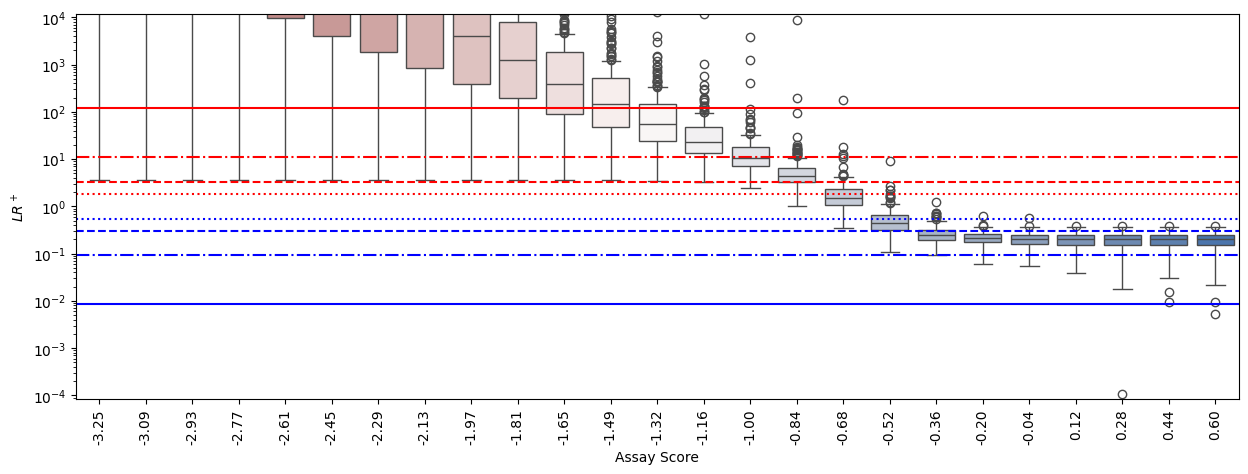

In [18]:
dataset_name = "Adamovich_BRCA1_Cisplatin"

STEP = 0.1
X = data[dataset_name][0]
# rng = np.arange(np.floor(X.min()),np.ceil(X.max()),STEP)
xm = X.min()
xM = X.max()
rng = np.linspace((xm // .05) * .05-.05, (xM // .05) * .05 + 0.05, 25)
# rng = np.arange(X.min(),X.max(),STEP)
LR = predict(rng, dataset_name, return_all=True)

fig,ax = plt.subplots(1,1,figsize=(15,5))
sns.boxplot(data=LR,ax=ax,palette=sns.color_palette("vlag_r",n_colors=LR.shape[1]))

ax.set_yscale('log')
_ = ax.set_xticks(ticks=range(len(rng)),labels=list(map(lambda v: f"{v:.2f}",rng)),rotation=90)
ax.set_xlabel("Assay Score")
ax.set_ylabel(r"$LR^+$")
pathogenic_thresholds, benign_thresholds = aggregate_thresholds(dataset_name)
for tP,tB,ls in zip(pathogenic_thresholds, benign_thresholds,[":","--","-.","-"]):
    ax.axhline(tP,ls=ls,color='r')
    ax.axhline(tB,ls=ls,color='b')
ax.set_ylim(benign_thresholds[-1] * 1e-2,pathogenic_thresholds[-1] * 1e2)

In [ ]:
def get_intervals

In [19]:
pathogenic_thresholds

array([  1.81545401,   3.29587325,  10.86278049, 118.        ])

In [20]:
from mave_calibration.evidence_thresholds import get_tavtigian_constant, pathogenicRulesPosterior, likelyPathogenicRulesPosterior, benignRulesPosterior, likelybenignRulesPosterior
import numpy as np

In [4]:
get_tavtigian_constant(.35)

np.int64(63)

In [5]:
C = 63
prior = .35
[np.round(likelyPathogenicRulesPosterior(C,prior,False),3) >= .9,
 np.round(pathogenicRulesPosterior(C,prior,False),3) >= .99,
 np.round(benignRulesPosterior(C,prior),3) <= .01,
 np.round(likelybenignRulesPosterior(C,prior,False),3) <= .1]

[array([ True,  True,  True,  True,  True,  True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True]),
 array([ True]),
 array([ True])]

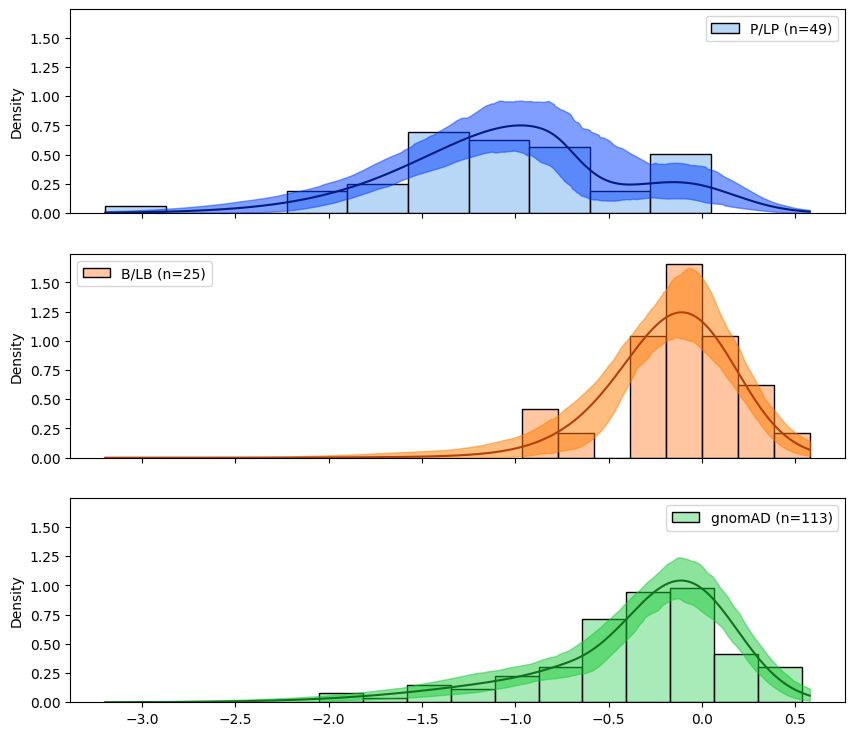

In [21]:
N_Samples = data[dataset_name][1].shape[1]
fig,ax = plt.subplots(N_Samples,1,figsize=(10,3*N_Samples),sharex=True,sharey=True)
X,S,sample_names = data[dataset_name]
rng = np.linspace(X.min(),X.max(),1000)
palette = sns.color_palette("pastel", N_Samples)
palette_3 = sns.color_palette("dark", N_Samples)
palette_2 = sns.color_palette("bright", N_Samples)
D = get_sample_density(rng, dataset_name)
sample_name_map = dict(p_lp="P/LP", b_lb="B/LB", gnomad="gnomAD", vus="VUS", synonymous="Synonymous",nonsynonymous="Nonsynonymous")
for i in range(N_Samples):
    sns.histplot(X[S[:,i]],ax=ax[i],stat='density',color=palette[i],label=f"{sample_name_map[sample_names[i]]} (n={S[:,i].sum():,d})")
    ax[i].plot(rng, D[i].mean(0),color=palette_3[i],)
    q = np.nanquantile(D[i], [0.025, .975], axis=0)
    ax[i].fill_between(rng, q[0], q[1], alpha=.5, color=palette_2[i])
    ax[i].legend()

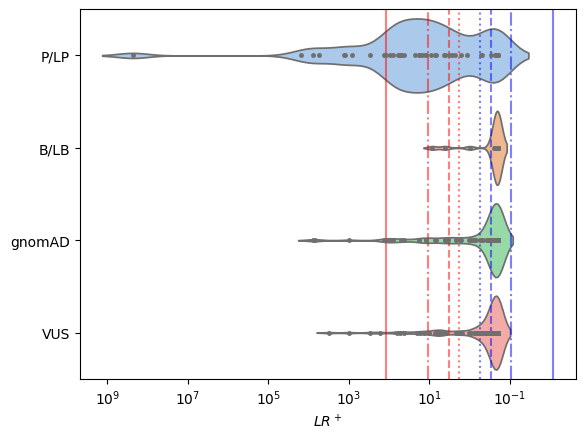

In [23]:
sample_name_map = dict(p_lp="P/LP", b_lb="B/LB", gnomad="gnomAD", vus="VUS", synonymous="Synonymous",nonsynonymous="Nonsynonymous")
prediction_set = {sample_name_map[k] : predict(X[S[:,i]],dataset_name) for i,k in enumerate(sample_names)}
obs = load_data(dataset_id=dataset_name,data_directory=data_dir,return_dict=True)
prediction_set['VUS'] = predict(obs['vus'],dataset_name)

sns.violinplot(prediction_set,
               orient='h',log_scale=True, bw_adjust=.5, inner='point',palette=sns.color_palette("pastel", len(prediction_set)))

plt.xlabel(r"$LR^+$")
pathogenic_thresholds, benign_thresholds = aggregate_thresholds(dataset_name)
for tP,tB,ls in zip(pathogenic_thresholds, benign_thresholds,[":","--","-.","-"]):
    plt.axvline(tP,ls=ls,color='r',alpha=.5)
    plt.axvline(tB,ls=ls,color='b',alpha=.5)
plt.gca().invert_xaxis()

In [ ]:
sns.histplot(obs['vus'])

In [ ]:
postThreshold = .99
prior = .35
postThreshold / (1 - postThreshold) * (1 - prior) / prior

In [ ]:
|